## Citibike Daily Trips Predictions

Tutorials Used:
[Scikit-Learn Linear Regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html),
[Digital Ocean Classifier](https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn)

Upgrade scikit-learn, may need to restart kernel.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
import os
import sklearn
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
project_id = os.environ['project_id']

In [4]:
trips_weather_by_date_query="""
SELECT trips_by_date.trip_date as date, dayofweek(trips_by_date.trip_date) as day_of_week, 
  month(trips_by_date.trip_date) as month, year(trips_by_date.trip_date) as year,
  trips_by_date.num_trip as num_trip, trips_by_date.avg_trip as avg_trip, weather.avg_temperature as temp
FROM
  (
  SELECT CAST(DATE(starttime) AS DATE) AS trip_date, COUNT(tripduration) AS num_trip, AVG(tripduration) AS avg_trip 
  FROM 
    [bigquery-public-data:new_york.citibike_trips],
    [citibike_tripdata.tripdata_2016_10_to_2017_12],
    [citibike_tripdata.tripdata_jc_2015_09_to_2017_12] 
  GROUP BY trip_date ORDER BY trip_date
  ) as trips_by_date
JOIN [weather.laguardia_20130701_20171231] as weather
ON trips_by_date.trip_date = weather.date
"""

trips_weather_by_date = gbq.read_gbq(query=trips_weather_by_date_query,dialect ='legacy', project_id=project_id)
trips_weather_by_date.head()

Requesting query... ok.
Job ID: 871b91d8-ba59-45fb-baf9-39df2af712d2
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1637 rows.

Total time taken 1.43 s.
Finished at 2018-04-05 22:11:56.


,date,day_of_week,month,year,num_trip,avg_trip,temp
0,2013-07-01,2,7,2013,16650,978.599279,75
1,2013-07-02,3,7,2013,22745,958.129567,76
2,2013-07-03,4,7,2013,21864,974.328485,78
3,2013-07-04,5,7,2013,22326,1273.108439,82
4,2013-07-05,6,7,2013,21842,1082.426609,84


In [5]:
trips_weather_by_date.dtypes

date            object
day_of_week      int32
month            int32
year             int32
num_trip         int32
avg_trip       float64
temp             int32
dtype: object

In [6]:
trips_weather_by_date.describe()

,day_of_week,month,year,num_trip,avg_trip,temp
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,4.001222,6.879658,2015.214417,32902.918143,914.586178,57.227856
std,2.001527,3.421604,1.315634,16929.400391,210.753427,17.608723
min,1.000000,1.000000,2013.000000,876.000000,569.723753,8.000000
25%,2.000000,4.000000,2014.000000,20384.000000,780.936392,44.000000
50%,4.000000,7.000000,2015.000000,32203.000000,880.166972,59.000000
75%,6.000000,10.000000,2016.000000,42832.000000,1009.718065,73.000000
max,7.000000,12.000000,2017.000000,75917.000000,4866.605023,92.000000


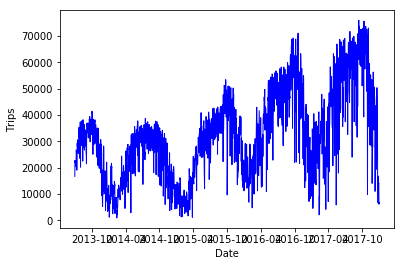

In [7]:
# Alias
twbd = trips_weather_by_date

plt.plot(twbd['date'], twbd['num_trip'], color='blue', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Trips')

plt.show()

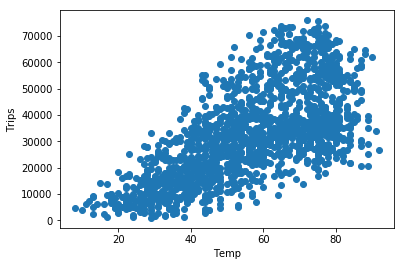

In [8]:
plt.scatter(twbd['temp'], twbd['num_trip'])

plt.xlabel('Temp')
plt.ylabel('Trips')

plt.show()

Cyclical Features

References:
- [Encoding Cyclical Features](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)
- [Feature Engineering](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

In [9]:
twbd['month_sin'] = np.sin((twbd['month'] - 1) * (2.0 * np.pi/12))
twbd['month_cos'] = np.cos((twbd['month'] - 1) * (2.0 * np.pi/12))

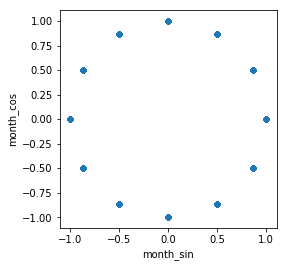

In [10]:
twbd.plot.scatter('month_sin','month_cos').set_aspect('equal');

In [11]:
twbd['day_of_week_sin'] = np.sin((twbd['day_of_week'] - 1) * (2.0 * np.pi/7))
twbd['day_of_week_cos'] = np.cos((twbd['day_of_week'] - 1) * (2.0 * np.pi/7))

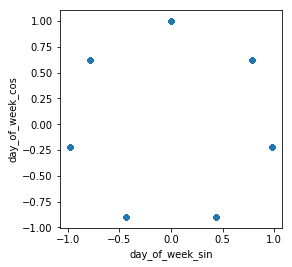

In [12]:
twbd.plot.scatter('day_of_week_sin','day_of_week_cos').set_aspect('equal');

Predict number of trips (label) given the temperature and date features.

In [13]:
# Organize our data
labels = twbd['num_trip']
features = twbd[['temp', 'year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']]

In [14]:
features.shape

(1637, 6)

In [15]:
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.33, random_state=42)

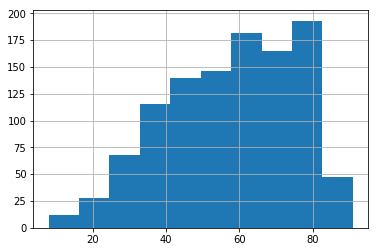

In [16]:
train['temp'].hist()

Normalize data into (0,1) range

Reference:
- [Normalize and Standardize](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)

In [17]:
# Training set temperature values to be normalized 
train_values = train['temp'].values
train_values = train_values.reshape((len(train_values), 1))  # reshape values into a column of rows

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_values)
train['temp_normalized'] = scaler.transform(train_values)

print('Min:', scaler.data_min_, 'Max:', scaler.data_max_)

Min: [8.] Max: [91.]


C:\Users\Chris\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Chris\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# Testing set temperature values to be normalized 
test_values = test['temp'].values
test_values = test_values.reshape((len(test_values), 1))  # reshape values into a column of rows

# Apply scaler fitted to training set values to testing values
test['temp_normalized'] = scaler.transform(test_values)

C:\Users\Chris\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
train = train.drop(columns=['temp'])
train.head()

,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,temp_normalized
1441,2017,0.781831,0.623490,5.000000e-01,-0.866025,0.843373
308,2014,0.781831,0.623490,8.660254e-01,-0.500000,0.602410
430,2014,-0.433884,-0.900969,-8.660254e-01,-0.500000,0.843373
370,2014,0.000000,1.000000,1.224647e-16,-1.000000,0.843373
678,2015,0.000000,1.000000,8.660254e-01,-0.500000,0.698795


In [20]:
test = test.drop(columns=['temp'])
test.head()

,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,temp_normalized
677,2015,-0.781831,0.623490,0.866025,-0.500000,0.602410
1589,2017,0.974928,-0.222521,-0.866025,0.500000,0.421687
984,2016,0.974928,-0.222521,0.866025,0.500000,0.481928
607,2015,-0.781831,0.623490,0.500000,0.866025,0.168675
1392,2017,0.781831,0.623490,0.866025,-0.500000,0.578313


In [21]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
# Make predictions
predictions = regr.predict(test)
print(predictions)

[24387.36402614 44026.15297673 29524.64320179  5784.55738806
 39449.25478812 36033.58276759 46146.2693465  27669.43226267
 36314.9296419   9394.13695882 39351.27687291 46372.25968812
 31864.32008792 40555.16238144 27196.24205197 28968.39176284
 28120.34521494 15102.29987684 43861.35717406 17228.92117471
 16542.08450451 33505.28490785 58847.55007602 50610.9398504
 21266.34604189 35434.16641316 37655.1837771  41619.36829741
 23312.33856795 26370.14164376 49068.24085865 11269.8151741
 40052.83068082 31557.03818448 37507.80754026 57518.68135097
 43578.27478947 18668.09592281 31896.62740793 27419.31339047
 15699.93300514 26593.60333477 20785.52386474 34242.73411933
 32549.84764422 56100.90591958 13830.23005498 28952.88749467
  5842.66587534 28177.5465169  11304.67998384 58389.67979285
 13604.3447116  20181.94797204 54164.33591973 34687.02085942
 35738.99538819 33209.64230291 35904.98020593 13389.75981516
 51861.61587774 11877.21308926 26156.88553677 35938.82721514
  4146.57277953 31294.2247

In [23]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_labels, predictions))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_labels, predictions))

Coefficients: 
 [ 6788.19440572  1492.36027889 -4648.1673635  -5677.33446156
 -3964.79992207 35193.93173814]
Mean squared error: 78072981.33
Variance score: 0.72


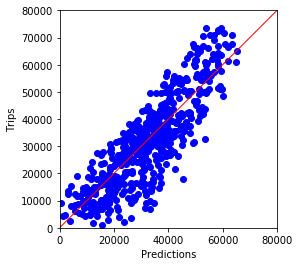

In [24]:
# Plot test_labels against predictions
plt.scatter(predictions, test_labels, color='blue')
plt.plot([0, 80000], [0, 80000], color='red', linestyle='-', linewidth=1)

plt.xlabel('Predictions')
plt.ylabel('Trips')

plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [25]:
test_table = twbd.loc[twbd['num_trip'].isin(test_labels)]
test_table.shape

(553, 11)

In [26]:
test_table.head()

,date,day_of_week,month,year,num_trip,avg_trip,temp,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,2013-07-01,2,7,2013,16650,978.599279,75,1.224647e-16,-1.0,0.781831,0.623490
15,2013-07-16,3,7,2013,29842,907.713055,87,1.224647e-16,-1.0,0.974928,-0.222521
18,2013-07-19,6,7,2013,26591,880.263172,92,1.224647e-16,-1.0,-0.974928,-0.222521
23,2013-07-24,4,7,2013,35271,935.532165,80,1.224647e-16,-1.0,0.433884,-0.900969
29,2013-07-30,3,7,2013,37334,949.690791,76,1.224647e-16,-1.0,0.974928,-0.222521


In [27]:
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
test_table = test_table.merge(predictions_df, left_index=True, right_index=True)
test_table.head()

,date,day_of_week,month,year,num_trip,avg_trip,temp,month_sin,month_cos,day_of_week_sin,day_of_week_cos,predictions
0,2013-07-01,2,7,2013,16650,978.599279,75,1.224647e-16,-1.0,0.781831,0.623490,24387.364026
15,2013-07-16,3,7,2013,29842,907.713055,87,1.224647e-16,-1.0,0.974928,-0.222521,28968.391763
18,2013-07-19,6,7,2013,26591,880.263172,92,1.224647e-16,-1.0,-0.974928,-0.222521,43861.357174
23,2013-07-24,4,7,2013,35271,935.532165,80,1.224647e-16,-1.0,0.433884,-0.900969,50610.939850
29,2013-07-30,3,7,2013,37334,949.690791,76,1.224647e-16,-1.0,0.974928,-0.222521,26370.141644


TODO: plotting

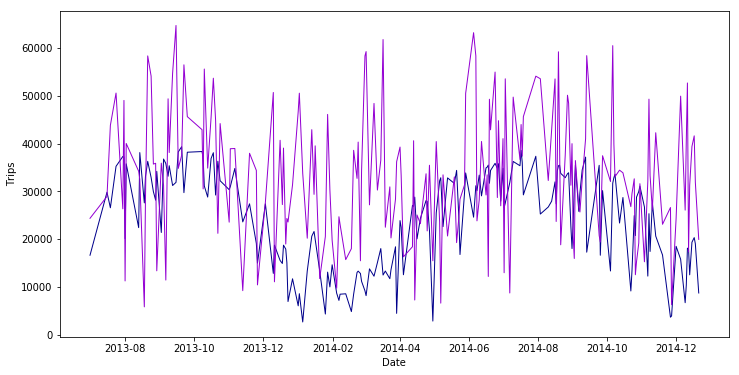

In [29]:
plt.figure(figsize=(12,6))

plt.plot(test_table['date'], test_table['num_trip'], color='darkblue', linewidth=1)
plt.plot(test_table['date'], test_table['predictions'], color='darkviolet', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Trips')

plt.show()

In [30]:
test_table.tail()

,date,day_of_week,month,year,num_trip,avg_trip,temp,month_sin,month_cos,day_of_week_sin,day_of_week_cos,predictions
530,2014-12-13,7,12,2014,12549,1015.938481,37,-0.5,0.866025,-0.781831,0.623490,31277.777822
532,2014-12-15,2,12,2014,19382,719.601589,42,-0.5,0.866025,0.781831,0.623490,39432.867023
534,2014-12-17,4,12,2014,20346,701.391133,47,-0.5,0.866025,0.433884,-0.900969,41650.406824
535,2014-12-18,5,12,2014,19051,674.668206,41,-0.5,0.866025,-0.433884,-0.900969,31926.607945
538,2014-12-21,1,12,2014,8747,745.802561,33,-0.5,0.866025,0.000000,1.000000,19971.329848
